# MNISTでセグメンテーションに挑戦



In [94]:
import os
import shutil
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
#from tqdm import tqdm

import torch
import torchvision
import torchvision.transforms as transforms

import binarybrain as bb

In [95]:
print(bb.get_version_string())
print(bb.get_device_name(0))

4.3.0
NVIDIA GeForce GTX 1660 SUPER


## 初期設定

In [96]:
# configuration
bb.set_device(0)

net_name               = 'MnistSemanticSegmentationSimple'
data_path              = os.path.join('./data/', net_name)

rtl_sim_path           = '../../verilog/mnist/tb_mnist_semantic_segmentationSimple'
rtl_module_name        = 'MnistSemanticSegmentationSimple'
output_velilog_file    = os.path.join(data_path, net_name + '.v')
sim_velilog_file       = os.path.join(rtl_sim_path, rtl_module_name + '.v')

bin_mode               = True
frame_modulation_size  = 3
depth_integration_size = 1
epochs                 = 64
mini_batch_size        = 32

## データセット準備

データセットを自作する
数値が中央に来るピクセル以外も学習させる必要がるため、28x28のMNSIT画像をタイル状に並べて学習データを作る
数字の無い位置も併せて11クラス分類できるようにデータを作成。

In [97]:
# 並べるタイル数
rows=3
cols=3

# dataset
dataset_path = './data/'
dataset_train = torchvision.datasets.MNIST(root=dataset_path, train=True, transform=transforms.ToTensor(), download=True)
dataset_test  = torchvision.datasets.MNIST(root=dataset_path, train=False, transform=transforms.ToTensor(), download=True)

# 面積の比率で重み作成(利用しない)
areas = np.zeros((11))
for img, label in dataset_train:
    img = img.numpy()
    areas[label] += np.mean(img)
    areas[10] += np.mean(1.0-img)
areas /= len(dataset_train)

weight = 1 / areas
weight /= np.max(weight)

# 人にとって背景の重要度は大きいので人為的に重みを載せる
weight[10] *= 10

def make_teacher_image(gen, rows, cols, margin=0):
    source_img  = np.zeros((1, rows*28, cols*28), dtype=np.float32)
    teaching_img = np.zeros((11, rows*28, cols*28), dtype=np.float32)
    for row in range(rows):
        for col in range(cols):
            x = col*28
            y = row*28
            img, label = gen.__next__()
            source_img[0,y:y+28,x:x+28] = img
            teaching_img[label,y:y+28,x:x+28] = img
            teaching_img[10,y:y+28,x:x+28] = (1.0-img)
    teaching_img = (teaching_img > 0.5).astype(np.float32)
    
    # 面積で重みを載せる
    for i in range(11):
        teaching_img[i] *= weight[i]
    
    # ランダムに反転
    if random.random() > 0.5:
        source_img = 1.0 - source_img

    # ノイズを載せる
    source_img += np.random.normal(0, np.random.uniform(0, 0.3), source_img.shape) 
    source_img = np.clip(source_img, 0.0, 1.0)

    return source_img, teaching_img[:,margin:-margin,margin:-margin]

def transform_data(dataset, n, rows, cols, margin):
    def data_gen():
        l = len(dataset)
        i = 0
        while True:
            yield dataset[i%l]
            i += 1
    
    gen = data_gen()
    source_imgs = []
    teaching_imgs = []
    for _ in range(n):
        x, t = make_teacher_image(gen, rows, cols, margin)
        source_imgs.append(x)
        teaching_imgs.append(t)
    return source_imgs, teaching_imgs

class MyDatasets(torch.utils.data.Dataset):
    def __init__(self, source_imgs, teaching_imgs, transforms=None):
        self.transforms = transforms
        self.source_imgs = source_imgs
        self.teaching_imgs = teaching_imgs
        
    def __len__(self):
        return len(self.source_imgs)

    def __getitem__(self, index):
        source_img = self.source_imgs[index]
        teaching_img = self.teaching_imgs[index]
        if self.transforms:
            source_img, teaching_img = self.transforms(source_img, teaching_img)
        return source_img, teaching_img

dataset_fname = os.path.join(data_path, 'dataset.pickle')
if os.path.exists(dataset_fname):
    with open(dataset_fname, 'rb') as f:
        source_imgs_train = pickle.load(f)
        teaching_imgs_train = pickle.load(f)
        source_imgs_test = pickle.load(f)
        teaching_imgs_test = pickle.load(f)
else:
    os.makedirs(data_path, exist_ok=True)
    source_imgs_train, teaching_imgs_train = transform_data(dataset_train, 4096, rows, cols, 28)
    source_imgs_test, teaching_imgs_test = transform_data(dataset_test, 128, rows, cols, 28)
    with open(dataset_fname, 'wb') as f:
        pickle.dump(source_imgs_train, f)
        pickle.dump(teaching_imgs_train, f)
        pickle.dump(source_imgs_test, f)
        pickle.dump(teaching_imgs_test, f)

my_dataset_train = MyDatasets(source_imgs_train, teaching_imgs_train)
my_dataset_test = MyDatasets(source_imgs_test, teaching_imgs_test)

loader_train = torch.utils.data.DataLoader(dataset=my_dataset_train, batch_size=mini_batch_size, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset=my_dataset_test, batch_size=mini_batch_size, shuffle=False)

In [98]:
def plt_data(x, y):
    plt.figure(figsize=(16,8))
    plt.subplot(1,12,1)
    plt.title('source')
    plt.imshow(x[0], 'gray')
    for i in range(11):
        plt.subplot(1,12,2+i)
        if i < 10:
            plt.title('class=%d'%i)
            plt.imshow(y[i], 'gray')
        else:
            plt.title('background')
            plt.imshow(y[i], 'gray')
    plt.tight_layout()
    _ = plt.show()

In [99]:
def view(net, loader, num=2):
    """表示確認"""
    n = 0;
    for x_imgs, t_imgs in loader:
        plt.figure(figsize=(16,8))
        x_buf = bb.FrameBuffer.from_numpy(np.array(x_imgs).astype(np.float32))
#       t_buf = bb.FrameBuffer.from_numpy(np.array(t_imgs).astype(np.float32))
        y_buf = net.forward(x_buf, train=False)
        result_imgs = y_buf.numpy()
        plt_data(x_imgs[0], result_imgs[0])
        n += 1
        if n >= num: break

torch.Size([1, 84, 84])
torch.Size([11, 28, 28])


<Figure size 1152x576 with 0 Axes>

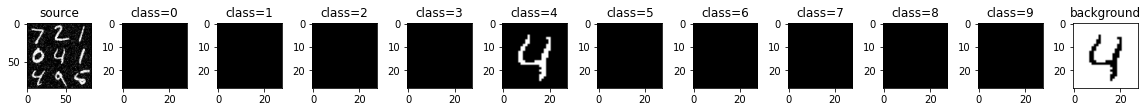

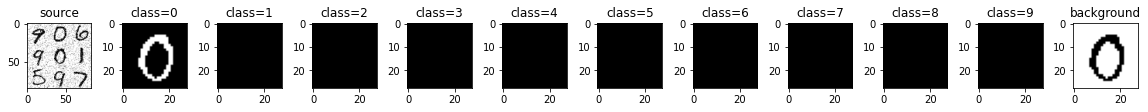

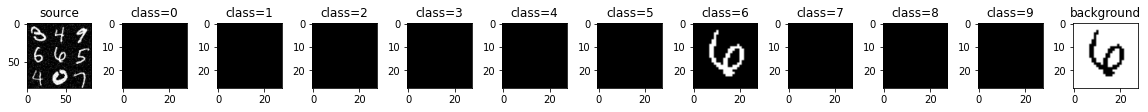

In [100]:
plt.figure(figsize=(16,8))
for source_imgs, teaching_imgs in loader_test:
    print(source_imgs[0].shape)
    print(teaching_imgs[0].shape)
    for i in range(min(mini_batch_size, 3)):
        plt_data(source_imgs[i], teaching_imgs[i])
    break

## ネットワーク構築
LUT-Netのみでは深いネットワークの学習が困難な模様なので、一旦バイナリDenseAffineで学習してから、補助層として使いながらLUT-Netを学習できる構造を検討する。
また、29段の畳み込み層で少なくとも１個の数字が畳み込み範囲に収まる広さを畳み込んだ後、数字の一部かどうか(セグメンテーション)と、どの数字か(10クラス分類)は個別に行う。

In [101]:
# バイナリ時は BIT型を使えばメモリ削減可能
bin_dtype = bb.DType.BIT if bin_mode else bb.DType.FP32

def create_lut_depthwise_conv(name, output_ch, filter_size=(3, 3), padding='valid', batch_norm=True, fw_dtype=bin_dtype):
    """LUTのDepthwiseConv層生成"""
    return bb.Convolution2d(
                bb.Sequential([
                    bb.DifferentiableLut([output_ch, 1, 1], connection='depthwise', batch_norm=batch_norm, name=(name + '_lut_dl_depthwise'), bin_dtype=fw_dtype),
                ]),
                filter_size=filter_size,
                padding=padding,
                name=name + '_lut_conv_depthwise',
                fw_dtype=fw_dtype)

def create_lut_conv1(name, output_ch, filter_size=(1, 1), padding='valid', connection='serial', batch_norm=True, fw_dtype=bin_dtype):
    """LUTのConv層生成(1段)"""
    return bb.Convolution2d(
                bb.DifferentiableLut([output_ch, 1, 1], connection=connection, batch_norm=batch_norm, name=(name + '_lut_dl'), bin_dtype=fw_dtype),
                filter_size=filter_size,
                padding=padding,
                name=(name + '_lut_conv'),
                fw_dtype=fw_dtype)

def create_lut_conv2(name, output_ch, filter_size=(1, 1), padding='valid', connection='serial', batch_norm=True, fw_dtype=bin_dtype):
    """LUTのConv層生成(2段)"""
    return bb.Convolution2d(
                bb.Sequential([
                    bb.DifferentiableLut([output_ch*6, 1, 1], connection=connection, batch_norm=batch_norm, name=(name + '_lut_dl0'), bin_dtype=fw_dtype),
                    bb.DifferentiableLut([output_ch,   1, 1], connection='serial', batch_norm=batch_norm, name=(name + '_lut_dl1'), bin_dtype=fw_dtype),
                ]),
                filter_size=filter_size,
                padding=padding,
                name=(name + '_lut_conv'),
                fw_dtype=fw_dtype)


def create_lut_conv_3x3(name, hidden_ch, output_ch, padding='valid', batch_norm=True, fw_dtype=bin_dtype):
    """初段用のLUTの3x3 Conv層生成"""
    return bb.Sequential([
            create_lut_conv1(name + '_dw', hidden_ch, filter_size=(3, 3), connection='random', fw_dtype=fw_dtype),
            create_lut_conv2(name + '_pw', output_ch, filter_size=(1, 1), connection='serial', fw_dtype=fw_dtype),
        ])

def create_dense_affine(name, output_ch, fw_dtype=bin_dtype):
    """バイナリ化したDenseAffine層生成"""
    return bb.Sequential([
                bb.DenseAffine([output_ch, 1, 1], name=(name + '_dense_affine')),
                bb.BatchNormalization(name=(name + '_dense_bn')),
                bb.Binarize(name=(name + '_dense_act'), bin_dtype=fw_dtype),
            ])

def create_dense_conv(name, output_ch, filter_size=(1, 1), padding='valid', fw_dtype=bin_dtype):
    """バイナリ化したDenseConv層生成"""
    return bb.Convolution2d(
                create_dense_affine(name, output_ch, fw_dtype),
                filter_size=filter_size,
                padding=padding,
                name=(name + '_dense_conv'),
                fw_dtype=fw_dtype)

LAYERS = 28+2

class SemanticSegmentationNetwork(bb.Sequential):
    """セグメンテーション＋分類ネットワーク"""
    def __init__(self):
        self.real2bin = bb.RealToBinary(frame_modulation_size=frame_modulation_size, bin_dtype=bin_dtype)
        self.bin2real = bb.BinaryToReal(frame_integration_size=frame_modulation_size, bin_dtype=bin_dtype)
        
        # Convolution層生成
        self.net_cnv = bb.Sequential()
        for i in range(LAYERS):
            layer_name = 'cnv%d'%(i)
            if i < LAYERS-2:
                cnv_dense = create_dense_conv(layer_name, 36, filter_size=(3, 3), padding='valid', fw_dtype=bin_dtype)
                if i == 0:
                    cnv_lut = create_lut_conv_3x3(layer_name, 36, 36, padding='valid', batch_norm=True, fw_dtype=bin_dtype)
                else:
                    cnv_lut = create_lut_conv_3x3(layer_name, 36*6, 36, padding='valid', batch_norm=True, fw_dtype=bin_dtype)
            else:
                if i < LAYERS-1:
                    cnv_dense = create_dense_conv(layer_name, 2*36, filter_size=(1, 1))
                    cnv_lut   = create_lut_conv2(layer_name, 2*36, filter_size=(1, 1))
                else:
                    cnv_dense = create_dense_conv(layer_name, 11, filter_size=(1, 1))
                    cnv_lut   = create_lut_conv2(layer_name, 11, filter_size=(1, 1))
                
            self.net_cnv.append(
                    bb.Switcher({
                        'dense': cnv_dense,
                        'lut': cnv_lut,
                    }, init_model_name='dense'))
        
        super(SemanticSegmentationNetwork, self).__init__([self.real2bin, self.net_cnv, self.bin2real])
    
    def set_input_shape(self, shape):
        shape = self.real2bin.set_input_shape(shape)
        shape = self.net_cnv.set_input_shape(shape)
        shape = self.bin2real.set_input_shape(shape)
        return shape
    
    def forward(self, x, train):
        x = self.real2bin.forward(x, train)
        x = self.net_cnv.forward(x, train)
        x = self.bin2real.forward(x, train)
        return x
    
    def backward(self, dy):
        dy = self.bin2real.backward(dy)
        dy = self.net_cnv.backward(dy)
#       dy = self.real2bin.backward(dy)
        return dy

In [102]:
# ネットワーク生成
net = SemanticSegmentationNetwork()
net.send_command("switch_model dense")
net.set_input_shape([1, rows*28, cols*28])
net.set_name(net_name)
net.send_command("binary true")

In [103]:
net.send_command("switch_model lut")
with open("layert_info_simple.txt", 'w') as f:
    f.write(net.get_info())
net.send_command("switch_model dense")


## 学習実施

学習を行います。そのままではこの深さのLUT-Networkの学習は困難であるため、DenseAffine での学習を先に行い、補助層として用いながら学習を行います。

In [104]:
def learning(data_path, net, epochs=2, learning_rate=0.001):
    """ネット全体の学習"""
    # learning
    loss      = bb.LossSoftmaxCrossEntropy()
    metrics   = bb.MetricsCategoricalAccuracy()
    optimizer = bb.OptimizerAdam(learning_rate=learning_rate)
    
    optimizer.set_variables(net.get_parameters(), net.get_gradients())

    for epoch in range(epochs):
        # learning
        loss.clear()
        metrics.clear()
        with tqdm(loader_train) as tqdm_loadr:
            for x_imgs, t_imgs in tqdm_loadr:
                x_buf = bb.FrameBuffer.from_numpy(np.array(x_imgs).astype(np.float32))
                t_buf = bb.FrameBuffer.from_numpy(np.array(t_imgs).astype(np.float32))
                y_buf = net.forward(x_buf, train=True)

                dy_buf = loss.calculate(y_buf, t_buf)
                metrics.calculate(y_buf, t_buf)
                
                net.backward(dy_buf)
                optimizer.update()

                tqdm_loadr.set_postfix(loss=loss.get(), acc=metrics.get())

        # test
        loss.clear()
        metrics.clear()
        for x_imgs, t_imgs in loader_test:
            x_buf = bb.FrameBuffer.from_numpy(np.array(x_imgs).astype(np.float32))
            t_buf = bb.FrameBuffer.from_numpy(np.array(t_imgs).astype(np.float32))

            y_buf = net.forward(x_buf, train=False)

            loss.calculate(y_buf, t_buf)
            metrics.calculate(y_buf, t_buf)

        bb.save_networks(data_path, net, backups=2)
        
        print('epoch[%d] : loss=%f acc=%f' % (epoch, loss.get(), metrics.get()))
        if epoch % 4 == 0:
            view(net, loader_test)

In [105]:
def learning_layer(data_path, net, index, epochs=2):
    """個別層の学習(index以降のみを学習)"""
    # learning
    loss     = bb.LossSoftmaxCrossEntropy()
    metrics  = bb.MetricsCategoricalAccuracy()
    optimizer = bb.OptimizerAdam()
    
    optimizer.set_variables(net.get_parameters(), net.get_gradients())

    for epoch in range(epochs):
        # learning
        loss.clear()
        metrics.clear()
        with tqdm(loader_train) as tqdm_loadr:
            for x_imgs, t_imgs in tqdm_loadr:
                x_buf = bb.FrameBuffer.from_numpy(np.array(x_imgs).astype(np.float32))
                t_buf = bb.FrameBuffer.from_numpy(np.array(t_imgs).astype(np.float32))
                
                x_buf = net.real2bin.forward(x_buf, train=False)
                for i in range(LAYERS):
                    x_buf = net.net_cnv[i].forward(x_buf, train=(i >= index))
                y_buf = net.bin2real.forward(x_buf, train=True)
                
                dy_buf = loss.calculate(y_buf, t_buf)
                metrics.calculate(y_buf, t_buf)
                
                dy_buf = net.bin2real.backward(dy_buf)
                for i in reversed(range(index, LAYERS)):
                    dy_buf = net.net_cnv[i].backward(dy_buf)
                
                optimizer.update()

                tqdm_loadr.set_postfix(loss=loss.get(), acc=metrics.get())

        # test
        loss.clear()
        metrics.clear()
        for x_imgs, t_imgs in loader_test:
            x_buf = bb.FrameBuffer.from_numpy(np.array(x_imgs).astype(np.float32))
            t_buf = bb.FrameBuffer.from_numpy(np.array(t_imgs).astype(np.float32))

            y_buf = net.forward(x_buf, train=False)
            
            loss.calculate(y_buf, t_buf)
            metrics.calculate(y_buf, t_buf)
        
        bb.save_networks(data_path, net, backups=2)
        
        print('epoch[%d] : loss=%f acc=%f' % (epoch, loss.get(), metrics.get()))
        if epoch % 4 == 0:
            view(net, loader_test)

In [106]:
def distillation_all(data_path, net, epochs=4, use_dense=True):
    """各層の蒸留"""
    
    # learning
    losses = []
    cnv_loss = []
    cnv_optimizer = []
    cnv_b2r = []
    for i in range(LAYERS):
        cnv_loss.append(bb.LossMeanSquaredError())
        cnv_optimizer.append(bb.OptimizerAdam())
        b2r = bb.BinaryToReal(frame_integration_size=frame_modulation_size, bin_dtype=bin_dtype)
        b2r.set_input_shape(net.net_cnv[i].get_output_shape())
        cnv_b2r.append(b2r)
        losses.append([])
    
    # LUT層をOptimizerに接続
    net.send_command("switch_model lut")
    net.send_command("parameter_lock false")
    for i in range(LAYERS):
        cnv_optimizer[i].set_variables(net.net_cnv[i].get_parameters(), net.net_cnv[i].get_gradients())
        
    net.send_command("switch_model dense")
    for epoch in range(epochs):
        # learning
        for i in range(LAYERS):
            cnv_loss[i].clear()
        
        with tqdm(loader_train) as tqdm_loadr:
            for x_imgs, t_imgs in tqdm_loadr:
                x_buf = bb.FrameBuffer.from_numpy(np.array(x_imgs).astype(np.float32))
                x_buf = net.real2bin.forward(x_buf, train=False)
                
                loss = 0
                for i in range(LAYERS):
                    net.net_cnv[i].send_command("switch_model dense")
                    y_buf = net.net_cnv[i].forward(x_buf, train=False)
                    t_buf = cnv_b2r[i].forward(y_buf, train=False)
                    net.net_cnv[i].send_command("switch_model lut")
                    xx_buf = net.net_cnv[i].forward(x_buf, train=True)
                    yy_buf = cnv_b2r[i].forward(xx_buf, train=True)
                    
                    dy_buf = cnv_loss[i].calculate(yy_buf, t_buf)
                    dy_buf = cnv_b2r[i].backward(dy_buf)
                    net.net_cnv[i].backward(dy_buf)
                    cnv_optimizer[i].update()
                    if use_dense:
                        x_buf = y_buf
                    else:
                        x_buf = xx_buf
                    
                    loss += cnv_loss[i].get()
                
                tqdm_loadr.set_postfix(loss=loss)
        
        bb.save_networks(data_path, net, backups=2)
        print('distillation epoch[%d]' % (epoch))
        for i in range(LAYERS):
            print('  cnv_loss[%d]=%f' % (i, cnv_loss[i].get()))
            losses[i].append(cnv_loss[i].get())
                
    return losses

In [107]:
def distillation_layer(data_path, net, index, epochs=4):
    """個別の層毎の蒸留"""
    # learning
    loss      = bb.LossMeanSquaredError()
    optimizer = bb.OptimizerAdam()
    
    cnv_layer = net.net_cnv[index]
    
    bin2real0 = bb.BinaryToReal(frame_integration_size=frame_modulation_size, bin_dtype=bin_dtype)
    bin2real1 = bb.BinaryToReal(frame_integration_size=frame_modulation_size, bin_dtype=bin_dtype)
    
    # LUT層をOptimizerに接続
    cnv_layer.send_command("switch_model lut")
    cnv_layer.send_command('parameter_lock false')
    optimizer.set_variables(cnv_layer.get_parameters(), cnv_layer.get_gradients())
    
    losses = []
    for epoch in range(epochs):
        # learning
        loss.clear()
        with tqdm(loader_train) as tqdm_loadr:
            for x_imgs, t_imgs in tqdm_loadr:
                # LUTに切り替えて前段計算
                net.send_command("switch_model lut")                
                x_buf = bb.FrameBuffer.from_numpy(np.array(x_imgs).astype(np.float32))
                x_buf = net.real2bin.forward(x_buf, train=False)
                for i in range(index):
                    x_buf = net.net_cnv[i].forward(x_buf, train=False)
                
                # dense に切り替えて教師データ生成
                cnv_layer.send_command("switch_model dense")
                t_buf = cnv_layer.forward(x_buf, train=False)
                t_buf = bin2real0.forward(t_buf, train=False)
                
                # LUTに戻して学習
                cnv_layer.send_command("switch_model lut")
                y_buf = cnv_layer.forward(x_buf, train=True)
                y_buf = bin2real1.forward(y_buf, train=True)
                
                dy_buf = loss.calculate(y_buf, t_buf)
                
                dy_buf = bin2real1.backward(dy_buf)
                cnv_layer.backward(dy_buf)
                optimizer.update()
                
                tqdm_loadr.set_postfix(loss=loss.get())
        
        bb.save_networks(data_path, net, backups=2)
        print('distillation epoch[%d] : loss=%f' % (epoch, loss.get()))
        losses.append(loss.get())
    return losses

In [108]:
# DenseAffine での学習
if not bb.load_networks(data_path, net, name='dense'):
    net.send_command("switch_model dense")
    net.send_command('parameter_lock false')
    learning(os.path.join(data_path, 'dense'), net, epochs=128)
    bb.save_networks(data_path, net, name='dense')
#   bb.save_networks(data_path, net, name='dense_layers', write_layers=True)

In [109]:
# 全体を大雑把に蒸留しておく
#if not bb.load_networks(data_path, net, name='distillation_all'):
#    loss_dense = distillation_all(os.path.join(data_path, 'distillation_all'), net, epochs=4, use_dense=True)
#    bb.save_networks(data_path, net, name='distillation_all')
# net.send_command("switch_model lut")
# view(net, loader_test)

In [ ]:
# DenseAffineを土台に順番にLUT学習
if not bb.load_networks(data_path, net, name=f'cnv{LAYERS-1}'):
    for i in range(LAYERS):
        layer_name = 'cnv%d'%i
        print('----- %s -----'%layer_name)
        if not bb.load_networks(data_path, net, name=layer_name):
            # 蒸留
            distillation_layer(os.path.join(data_path, layer_name), net, i, epochs=8)

            # 全体初期化
            net.send_command("switch_model dense")
            net.send_command('parameter_lock true')

            # LUT切り替え
            for j in range(i+1):
                net.net_cnv[j].send_command("switch_model lut")
            view(net, loader_test)

            # 個別学習
            net.net_cnv[i].send_command('parameter_lock false')
    #       learning(os.path.join(data_path, layer_name), net, epochs=2)  # 蒸留で代替

            # 後段含めた学習
            net.send_command('parameter_lock false')
            for j in range(i):
                net.net_cnv[j].send_command("parameter_lock true")
            learning_layer(os.path.join(data_path, layer_name), net, i, epochs=16)
    #       learning(os.path.join(data_path, layer_name), net, epochs=2)

            # 保存
            bb.save_networks(data_path, net, name=layer_name)

In [111]:
# 最終版を記録
bb.save_networks(data_path, net, name='final')

'final'

<Figure size 1152x576 with 0 Axes>

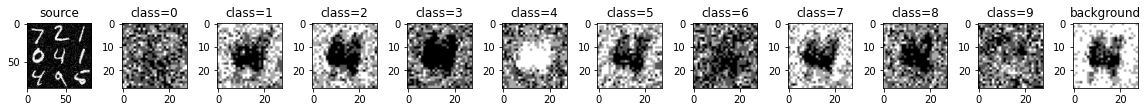

<Figure size 1152x576 with 0 Axes>

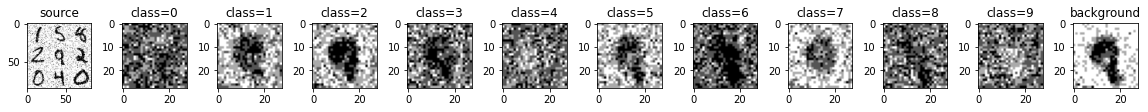

<Figure size 1152x576 with 0 Axes>

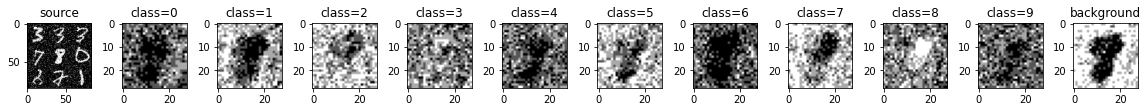

<Figure size 1152x576 with 0 Axes>

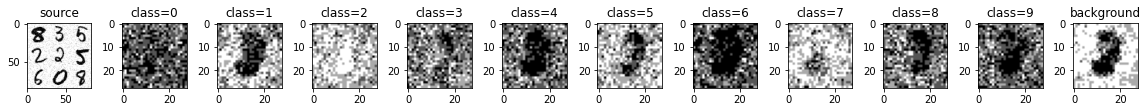

In [112]:
# 学習結果の表示
view(net, loader_test, 8)

## RTL出力

Verilog 変換を行います

In [113]:
os.makedirs(rtl_sim_path, exist_ok=True)

# export verilog
with open(output_velilog_file, 'w') as f:
    f.write('`timescale 1ns / 1ps\n\n')
    bb.dump_verilog_lut_cnv_layers(f, 'MnistSemanticSegmentation', net.net_cnv)

# Simulation用ファイルに上書きコピー
shutil.copyfile(output_velilog_file, sim_velilog_file)

# Simulationで使う画像の生成
def img_geneator():
    for data in dataset_test:
        yield data[0] # 画像とラベルの画像の方を返す

img = (bb.make_image_tile(720//28+1, 1280//28+1, img_geneator())*255).astype(np.uint8)
bb.write_ppm(os.path.join(rtl_sim_path, 'mnist_test_160x120.ppm'), img[:,:120,:160])
bb.write_ppm(os.path.join(rtl_sim_path, 'mnist_test_640x480.ppm'), img[:,:480,:640])
bb.write_ppm(os.path.join(rtl_sim_path, 'mnist_test_1280x720.ppm'), img[:,:720,:1280])

In [114]:
bb.load_networks(data_path, net, name='final')

True

<Figure size 1152x576 with 0 Axes>

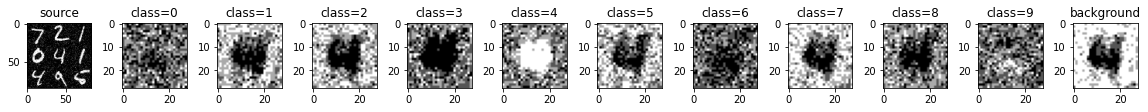

<Figure size 1152x576 with 0 Axes>

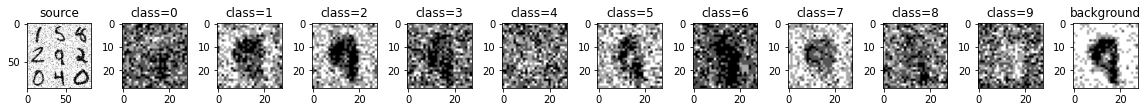

<Figure size 1152x576 with 0 Axes>

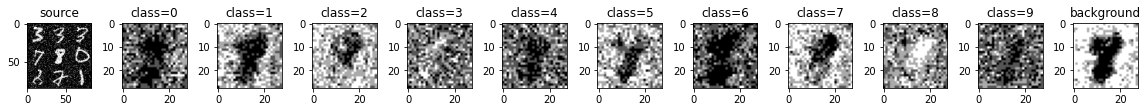

<Figure size 1152x576 with 0 Axes>

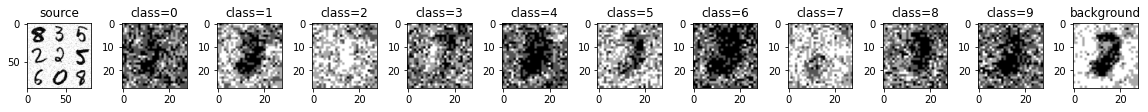

In [115]:
view(net, loader_test, 8)

## 評価を行う

In [232]:
# Simulationで使う画像の生成
def img_geneator():
    for data in dataset_test:
        yield data[0] # 画像とラベルの画像の方を返す

img_mnist = (bb.make_image_tile(720//28+1, 1280//28+1, img_geneator())*255).astype(np.uint8)
bb.write_ppm(os.path.join(rtl_sim_path, 'mnist_test_160x120.ppm'), img_mnist[:,:120,:160])
bb.write_ppm(os.path.join(rtl_sim_path, 'mnist_test_640x480.ppm'), img_mnist[:,:480,:640])
bb.write_ppm(os.path.join(rtl_sim_path, 'mnist_test_1280x720.ppm'), img_mnist[:,:720,:1280])

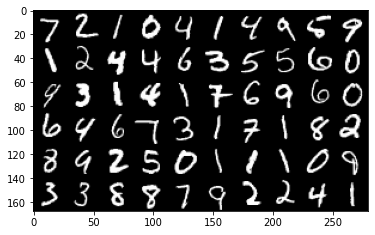

In [240]:
# 評価用画像の切り出し
img_eval = img_mnist[0][:28*6,:28*10]
plt.imshow(img_eval, 'gray')

In [241]:
# 閾値を変えて10パターンの画像を作成
img = np.ndarray((10, 1, img_eval.shape[0], img_eval.shape[1]), dtype=np.float32)
for i in range(10):
    th = 0.5 + (i-5)*0.08
    img[i][0][img_eval <  th] = 0.0
    img[i][0][img_eval >= th] = 1.0
x_buf = bb.FrameBuffer.from_numpy(img)
y_buf = net.forward(x_buf, train=False)
y = y_buf.numpy()

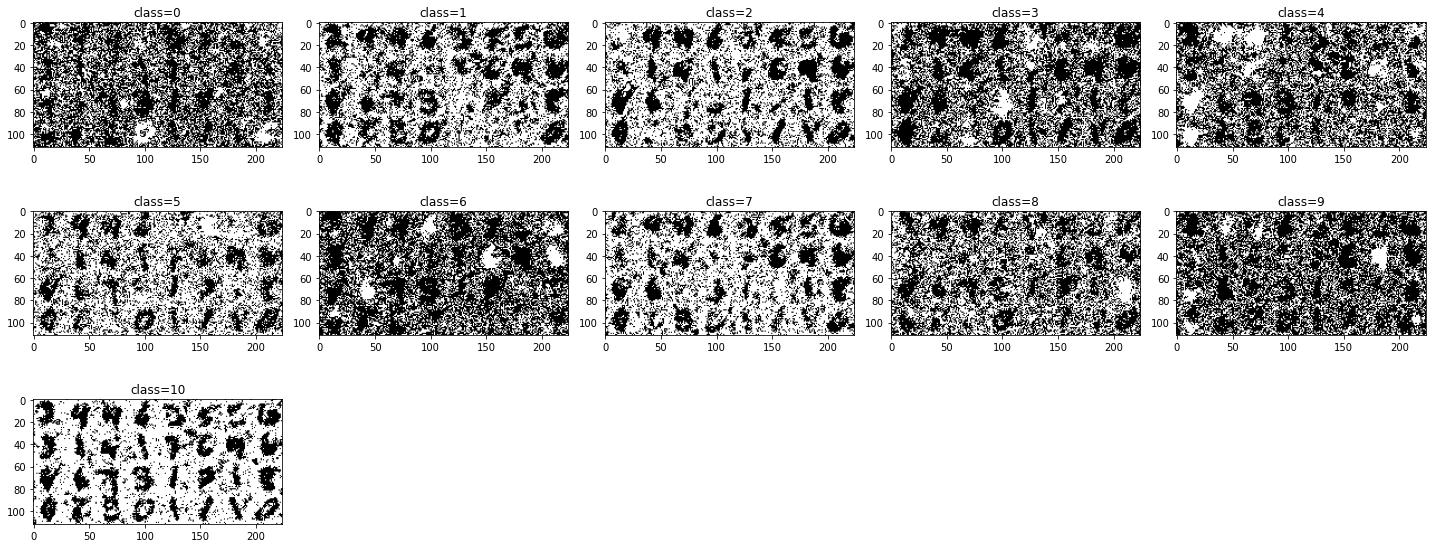

In [242]:
# 閾値 0.5 の1枚だけの結果
import cv2
os.makedirs(f"{data_path}/outeput_image", exist_ok=True)
plt.figure(figsize=(20,8))
for i in range(11):
    cv2.imwrite(f"{data_path}/outeput_image/th1_class{i}.png", y[5][i]*255)
    plt.subplot(3, 5, i+1)
    plt.imshow(y[5][i], 'gray')
    plt.title('class=%d'%i)
plt.tight_layout()

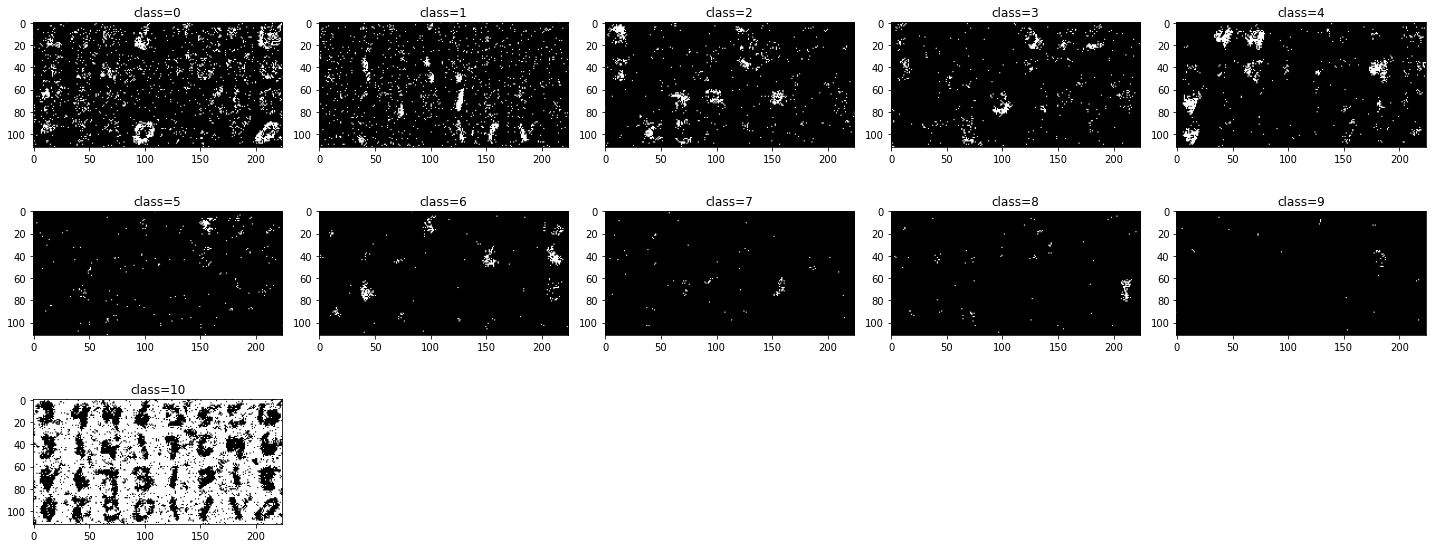

In [243]:
# 閾値違いを平均化した結果
y_mean = np.mean(y, axis=0)
y_mean[10] *= 1.5
y_class = np.argmax(y_mean, axis=0)
plt.figure(figsize=(20,8))
for i in range(11):
    cv2.imwrite(f"{data_path}/outeput_image/th10_class{i}.png", (y_class==i)*255)
    plt.subplot(3, 5, i+1)
    plt.imshow(y_class==i, 'gray')
    plt.title('class=%d'%i)
plt.tight_layout()